# AWS Public Blockchain - BTC Examples

In [2]:
pip install PyAthena

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.0 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import boto3
import pandas as pd
from pyathena import connect

In [10]:
S3_BUCKET=!(aws cloudformation list-exports --query "Exports[?Name=='public-blockchain-athena-results'].Value" --output text)
S3_BUCKET=S3_BUCKET[0]

In [11]:
conn = connect(s3_staging_dir='s3://'+S3_BUCKET+'/results/')

### Get number of blocks

In [13]:
df = pd.read_sql("select count(*) as block_count from btc.blocks", conn)
df

,block_count
0,754383


### Get number of transactions per date

In [14]:
df = pd.read_sql("select date,sum(transaction_count) as tx_count from btc.blocks group by date order by date", conn)
df

,date,tx_count
0,2009-01-03,1
1,2009-01-09,14
2,2009-01-10,61
3,2009-01-11,93
4,2009-01-12,101
...,...,...
4995,2022-09-12,268971
4996,2022-09-13,260108
4997,2022-09-14,270309
4998,2022-09-15,277041


### Get details for block by number

In [15]:
block_number=700000

In [16]:
df = pd.read_sql("select * from btc.blocks where number="+str(block_number), conn)
df.iloc[0]

hash                 0000000000000000000590fc0f3eba193a278534220b2b...
size                                                           1276422
stripped_size                                                   907224
weight                                                         3998094
number                                                          700000
version                                                     1073733636
merkle_root          1f8d213c864bfe9fb0098cecc3165cce407de88413741b...
timestamp                                          2021-09-11 04:14:32
nonce                                                       2881644503
bits                                                          170f48e4
coinbase_param       0360ae0a2cfabe6d6d078b52bc69cf0982356d3eb439ef...
transaction_count                                                 1276
mediantime                                         2021-09-11 03:31:28
difficulty                                       18415156832118.238281
chainw

### Get details for transaction by hash

In [17]:
tx_hash='c86aecd51212a81bfdb26077aaceb1d9822802bb48fb542e41502487060d7828'

In [18]:
df = pd.read_sql("select * from btc.transactions where hash='"+tx_hash+"'", conn)
df.iloc[0]

hash               c86aecd51212a81bfdb26077aaceb1d9822802bb48fb54...
size                                                             944
virtual_size                                                     944
version                                                            1
lock_time                                                          0
block_hash         00000000000000002e4528b160d664e13ff5755a3f0db8...
block_number                                                  308631
block_timestamp                                  2014-06-30 17:40:22
input_count                                                        2
output_count                                                       1
input_value                                                   0.0118
output_value                                                  0.0117
is_coinbase                                                    False
fee                                                           0.0001
inputs             [{index=0, spen

### Get inputs by transaction hash

In [19]:
df = pd.read_sql("SELECT t.hash,"+
                 "input.index as input_index,input.script_asm as input_script_asm,input.script_hex as input_script_hex,input.sequence as input_sequence,input.required_signatures as inputrequired_signatures,input.type as input_type,input.address as input_address,input.value as input_value from btc.transactions t,UNNEST(t.inputs) as t(input) "+
                 "where t.hash='"+tx_hash+"' order by t.hash,input.index", conn)
df

,hash,input_index,input_script_asm,input_script_hex,input_sequence,inputrequired_signatures,input_type,input_address,input_value
0,c86aecd51212a81bfdb26077aaceb1d9822802bb48fb54...,0,0 30440220066e7dc834160943c3b653f2bf4c32388f1f...,004730440220066e7dc834160943c3b653f2bf4c32388f...,4294967295,3,multisig,None,0.0099
1,c86aecd51212a81bfdb26077aaceb1d9822802bb48fb54...,1,0 304402204f792b883b43fb71c6406069d6a1aec799e2...,0047304402204f792b883b43fb71c6406069d6a1aec799...,4294967295,1,scripthash,3A5WHQ76i6vmR5nB6tStv1PZxJoxo4MtBk,0.0019


### Get outputs by transaction hash

In [20]:
df = pd.read_sql("SELECT t.hash,"+
                 "output.index as output_index,output.script_asm as output_script_asm,output.script_hex as output_script_hex,output.required_signatures as output_required_signatures,output.type as output_type,output.address as output_address,output.value as output_value from btc.transactions t,UNNEST(t.outputs) as t(output) "+
                 "where t.hash='"+tx_hash+"' order by t.hash,output.index", conn)
df

,hash,output_index,output_script_asm,output_script_hex,output_required_signatures,output_type,output_address,output_value
0,c86aecd51212a81bfdb26077aaceb1d9822802bb48fb54...,0,3 044959de239fc3eb312a5e6541f6bfa4c3a422f69b6b...,5341044959de239fc3eb312a5e6541f6bfa4c3a422f69b...,3,multisig,None,0.0117


### Get transaction inputs and outputs by transaction hash

In [21]:
df = pd.read_sql("SELECT A.*,B.input_index,B.input_script_asm,B.input_script_hex,B.input_type,B.input_address,B.input_value FROM (SELECT t.hash,t.size,t.virtual_size,t.version,t.lock_time,t.block_hash,t.block_number,t.block_timestamp,t.input_count,t.output_count,t.input_value,t.output_value,t.is_coinbase,t.fee,"+
                 "output.index as output_index,output.script_asm as output_script_asm,output.script_hex as output_script_hex,output.required_signatures as output_required_signatures,output.type as output_type,output.address as output_address,output.value as output_value "+
                 "from btc.transactions t,UNNEST(t.outputs) as t(output) "+
                 "where t.hash='"+tx_hash+"') A FULL OUTER JOIN "+
                 "(SELECT t.hash,"+
                 "input.index as input_index,input.script_asm as input_script_asm,input.script_hex as input_script_hex,input.type as input_type,input.address as input_address,input.value as input_value from btc.transactions t,UNNEST(t.inputs) as t(input) "+
                 "where t.hash='"+tx_hash+"' order by t.hash,input.index) B ON A.hash=B.hash and A.output_index=B.input_index order by A.hash,A.output_index", conn)
df

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,input_count,output_count,...,output_required_signatures,output_type,output_address,output_value,input_index,input_script_asm,input_script_hex,input_type,input_address,input_value
0,c86aecd51212a81bfdb26077aaceb1d9822802bb48fb54...,944.0,944.0,1.0,0.0,00000000000000002e4528b160d664e13ff5755a3f0db8...,308631.0,2014-06-30 17:40:22,2.0,1.0,...,3.0,multisig,None,0.0117,0,0 30440220066e7dc834160943c3b653f2bf4c32388f1f...,004730440220066e7dc834160943c3b653f2bf4c32388f...,multisig,None,0.0099
1,None,NaN,NaN,NaN,NaN,None,NaN,NaT,NaN,NaN,...,NaN,None,None,NaN,1,0 304402204f792b883b43fb71c6406069d6a1aec799e2...,0047304402204f792b883b43fb71c6406069d6a1aec799...,scripthash,3A5WHQ76i6vmR5nB6tStv1PZxJoxo4MtBk,0.0019


## Charts

### Fees over Time (in BTC)

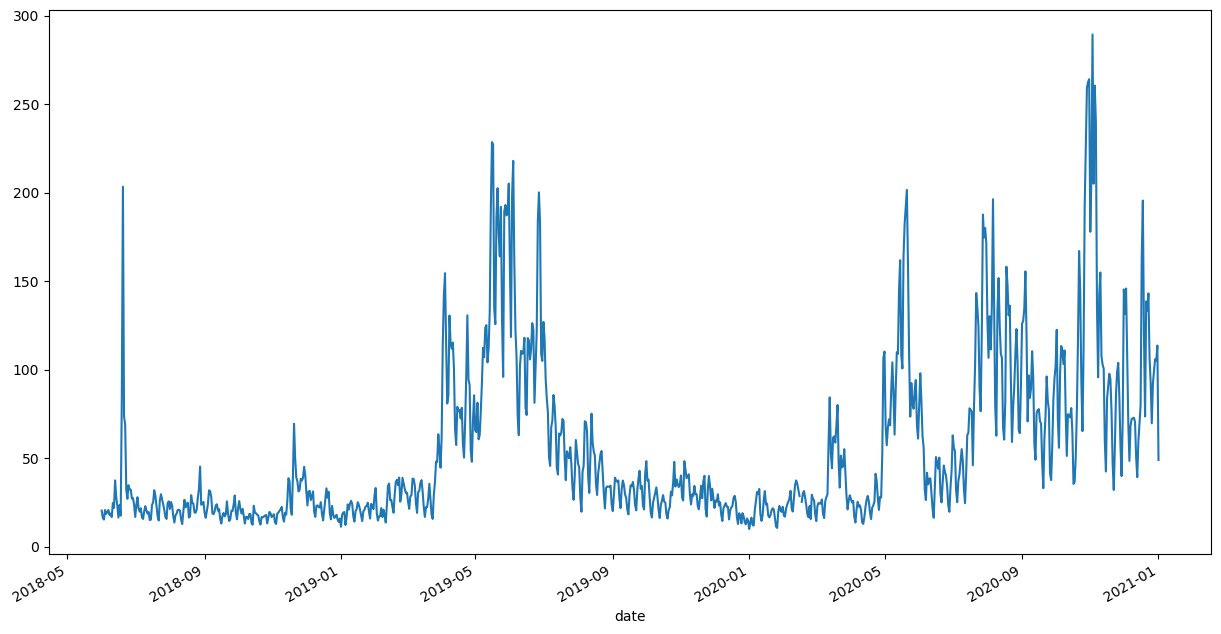

In [22]:
%matplotlib inline
df = pd.read_sql("select date,sum(fee) as fees from btc.transactions where date>='2018-06-01' and date<='2021-01-01' group by date", conn)
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
del df['date']
df["fees"].plot(figsize=(15,8))

### Transactions per Second

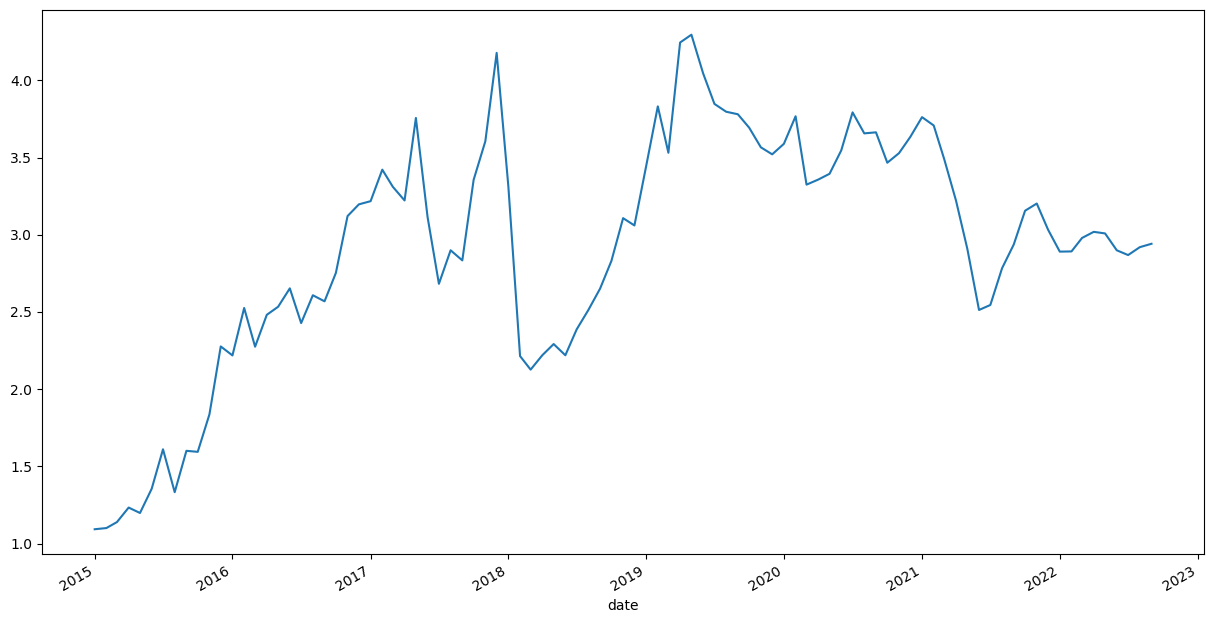

In [23]:
%matplotlib inline
df = pd.read_sql("""
select date_trunc('month',cast(date as date)) as date, avg(transactions_per_sec) as transactions_per_sec from (
    select date, cast(count(*) as double)/(24*60*60) as transactions_per_sec
    from btc.transactions
    where date>'2015-01-01'
    group by date) group by  date_trunc('month',cast(date as date))
""", conn)
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
del df['date']
df["transactions_per_sec"].plot(figsize=(15,8))

### Historical Price Data 

Please note the following cell requires market data loaded first. Please run through the ***load-marketdata.ipynb*** notebook first.

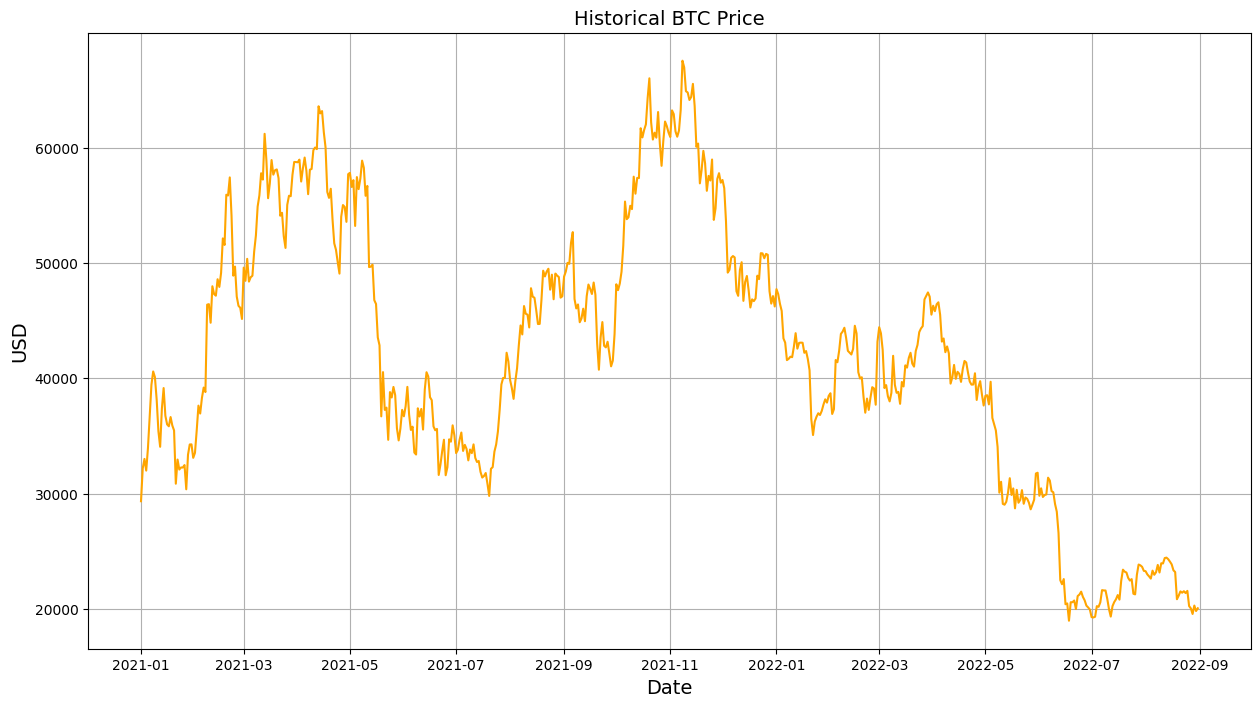

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_sql("""
SELECT CAST(open_time AS DATE) as date,close FROM marketdata.crypto where ticker='BTCUSDT' and extract(MINUTE from open_time)=59 and extract(HOUR from open_time)=23 and open_time > TIMESTAMP '2021-01-01 00:00:00' order by open_time
""", conn)
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
del df['date']

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(df.index, df['close'], color='orange')
plt.title('Historical BTC Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.grid(True)
plt.show()

### Total Supply over Time

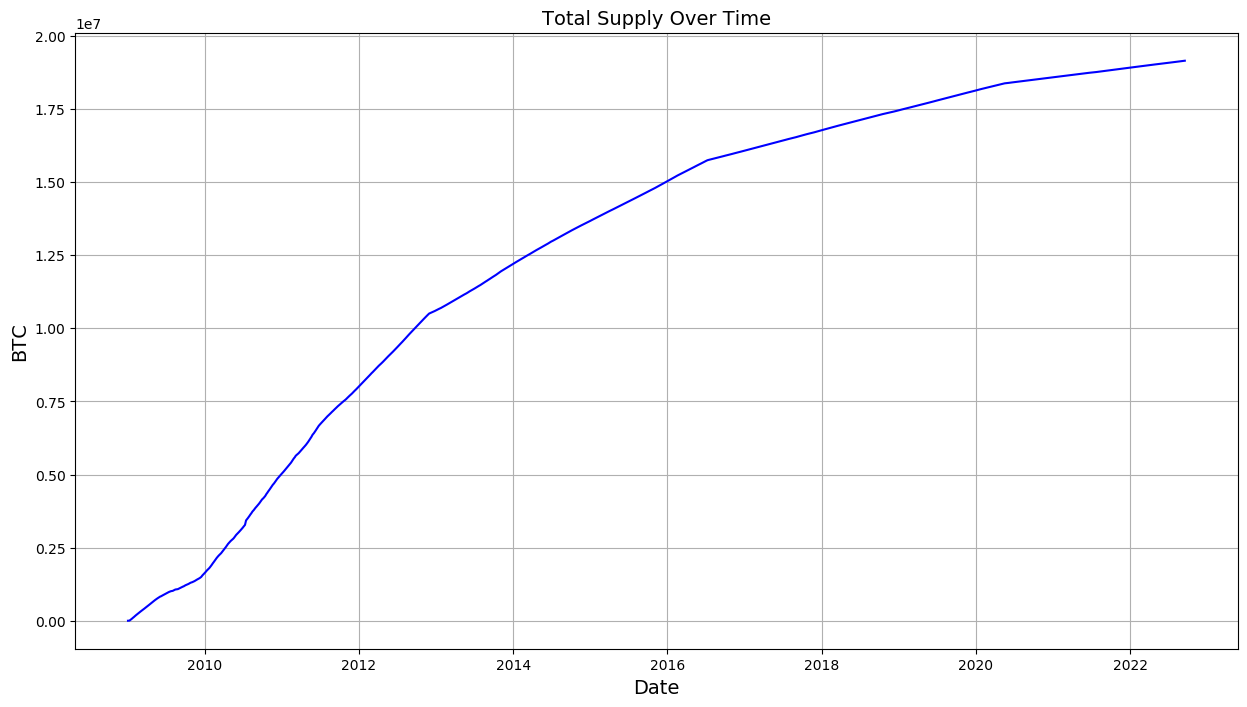

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
#(CASE WHEN number<210000 THEN 50 WHEN number<420000 THEN 25 WHEN number<630000 THEN 12.5 ELSE 6.25 END)
df = pd.read_sql(""" 
select date, (CASE 
  WHEN number<210000 THEN 50*number
  WHEN number<420000 THEN (210000-1)*50+25*(number-210000) 
  WHEN number<630000 THEN (210000-1)*50+25*210000+12.5*(number-420000)
  ELSE (210000-1)*50+25*210000+12.5*210000+6.25*(number-630000) 
  END) as reward
from (select cast(date as date) as date,max(number) as number from btc.blocks group by date) order by date 
""", conn)
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
del df['date']

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(df.index, df['reward'], color='blue')
plt.title('Total Supply Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('BTC', fontsize=14)
plt.grid(True)
plt.show()

### Weekly Transaction Volume (USD) 

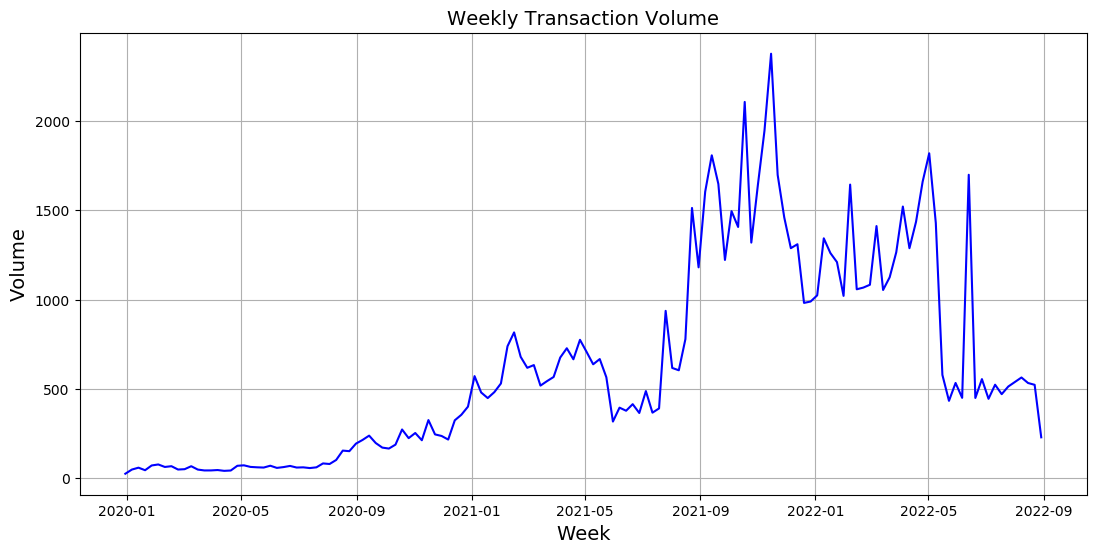

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_sql("""
WITH 
  daily_amt AS (SELECT cast(date AS date) AS date, sum(input_value) AS amt FROM btc. transactions where date>='2018-01-01' GROUP BY date),
  daily_price as (SELECT cast(open_time AS DATE) AS date, close AS price FROM marketdata.crypto where ticker='BTCUSDT' and extract(MINUTE FROM open_time)=59 and extract(HOUR FROM open_time)=23 and open_time >= TIMESTAMP '2020-01-01 00:00:00')
SELECT date_trunc('week', date) AS week, sum(transaction_volume) / 1000000000 AS transaction_volume, avg(price) AS price FROM (SELECT A.date, B.amt * A.price AS transaction_volume, a.price FROM daily_price A JOIN daily_amt B ON A.date=B.date) GROUP BY date_trunc('week', date) ORDER BY date_trunc('week',date) 
""", conn)
df.set_index(pd.DatetimeIndex(df['week']),inplace=True)

plt.rcParams["figure.figsize"] = (13,6)
plt.plot(df.index, df['transaction_volume'], color='blue')
plt.title('Weekly Transaction Volume', fontsize=14)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.show()

### Network Value to Transactions (NVT) Ratio

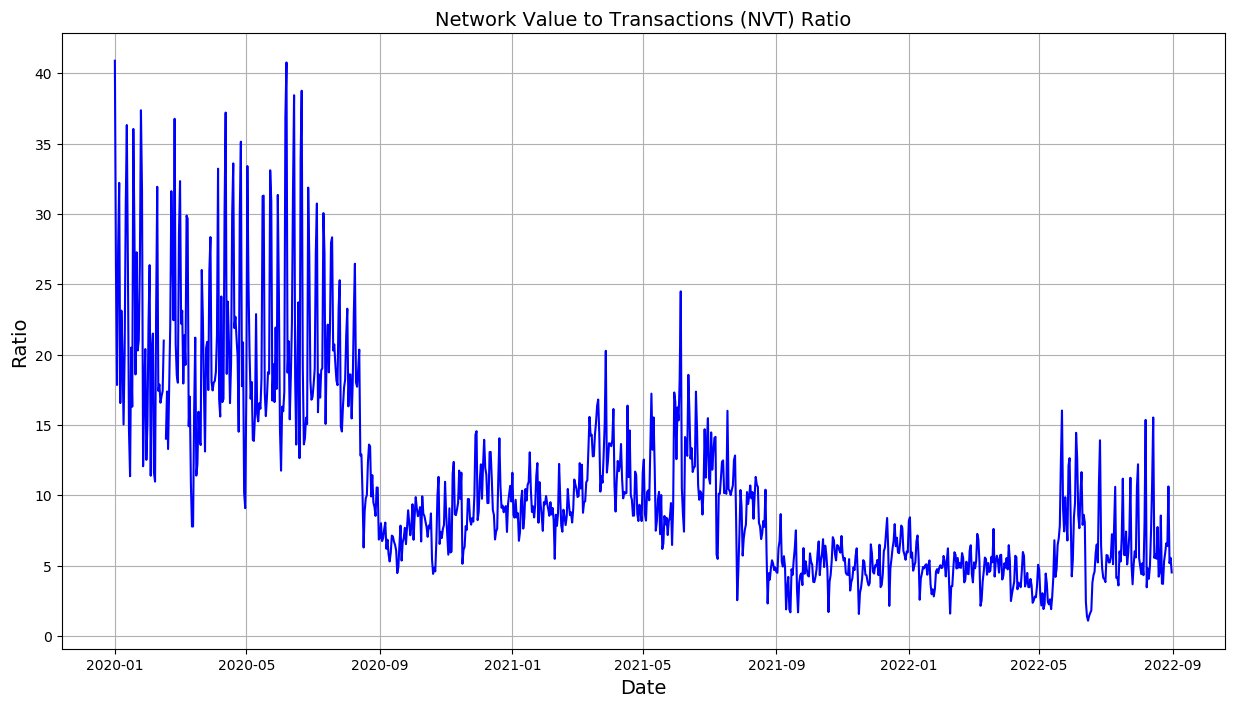

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_sql("""
with daily_amt as 
  (select cast(date as date) as date,sum(input_value) as amt from btc.transactions where date>='2020-01-01' group by date),
     daily_price as
  (SELECT CAST(open_time AS DATE) as date,close as price FROM marketdata.crypto where ticker='BTCUSDT' and extract(MINUTE from open_time)=59 and extract(HOUR from open_time)=23 and open_time >= TIMESTAMP '2020-01-01 00:00:00'),
    supply_amt as 
  (select date, (CASE 
  WHEN number<210000 THEN 50*number
  WHEN number<420000 THEN (210000-1)*50+25*(number-210000) 
  WHEN number<630000 THEN (210000-1)*50+25*210000+12.5*(number-420000)
  ELSE (210000-1)*50+25*210000+12.5*210000+6.25*(number-630000) 
  END) as supply
  from (select cast(date as date) as date,max(number) as number from btc.blocks group by date) order by date) 
select A.date,(C.supply*A.price)/(B.amt*A.price) as nvt from daily_price A JOIN daily_amt B ON A.date=B.date JOIN supply_amt C ON B.date=C.date order by A.date
""", conn)
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
del df['date']

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(df.index, df['nvt'], color='blue')
plt.title('Network Value to Transactions (NVT) Ratio', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ratio', fontsize=14)
plt.grid(True)
plt.show()